# BA, 512²

| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  12/05/2024          |
| Updated |  12/30/2024          |

In [1]:
#===============================================================================
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np
import pandas as pd

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
res = 512
n_p = 'np1'
vers = [[f'dust_particles/{n_p}', 'dotted'],
        ['dust_fluid', 'solid']]
pcm_codes = [[f'{vers[0][0]}/{res}', 'Athena'],
             [f'{vers[0][0]}/{res}', 'Athena++'],
             [f'{vers[0][0]}/{res}', 'Pencil'],
             [f'{vers[1][0]}/{res}', 'Athena++'],
             [f'{vers[1][0]}/{res}', 'FARGO3D'],
             [f'{vers[1][0]}/{res}', 'Idefix'],
             [f'{vers[1][0]}/{res}', 'LA-COMPASS']]
plt_codes = [[['Athena', 'tab:green'], ['Athena++', 'tab:red'],
              ['Pencil', 'tab:blue']],
             [['Athena++', 'tab:purple'], ['FARGO3D', 'tab:olive'],
              ['Idefix', 'tab:orange'], ['LA-COMPASS', 'tab:cyan']]]

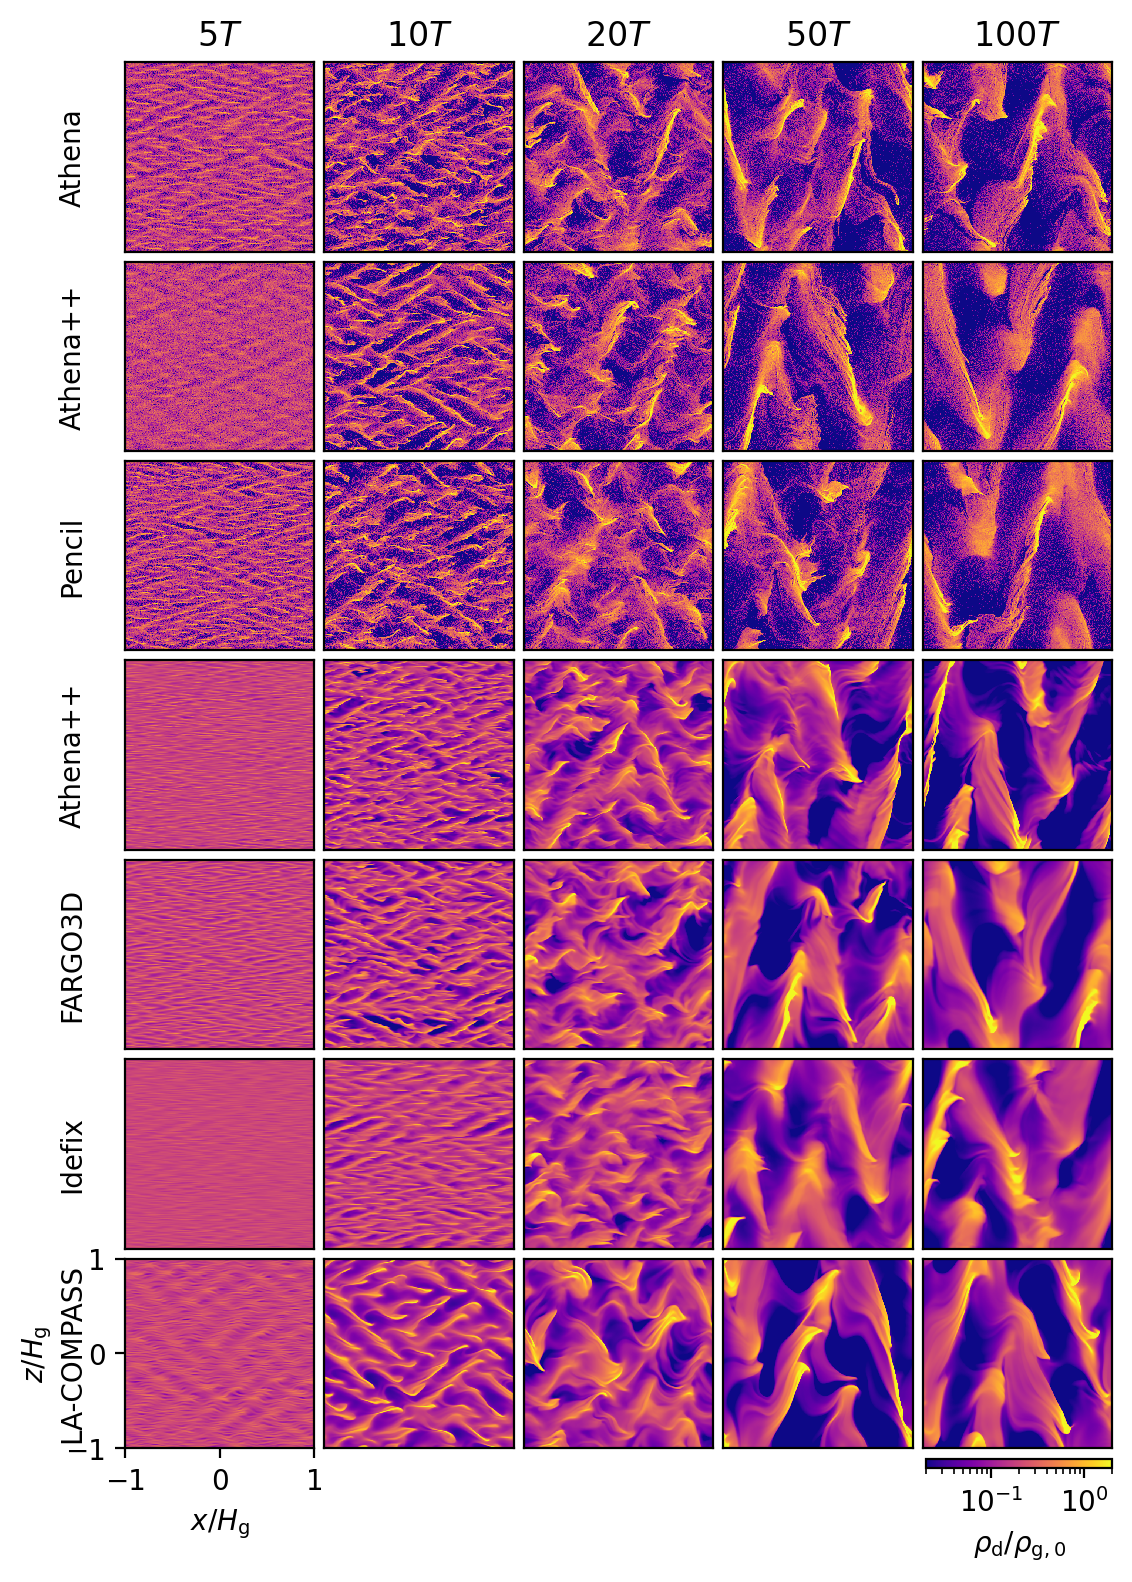

In [4]:
#===============================================================================
times = [5, 10, 20, 50, 100]
vmin, vmax = 2e-2, 2e0 # BA CPDD > 85%; CPDD < 5%

# Plot
fig = plt.figure(figsize=(8, 9), dpi=200)
ax_grid = AxesGrid(fig, 111, nrows_ncols=(len(pcm_codes), len(times)), axes_pad=0.05,
                   share_all=True, label_mode='1')
for j, code in enumerate(pcm_codes):
    path = f'{root}/{model}/{problem}/{code[0]}/{code[1]}'
    row = j*len(times)
    for i, time in enumerate(times):
        if j == 0:
            ax_grid[i].set_title(rf'{time}$T$')
        if i == 0:
            ax_grid[row].text(-0.35, 0.5, f'{code[1]}', va='center',
                              rotation='vertical',
                              transform=ax_grid[row].transAxes)
        snapshot = np.load(f'{path}/{time}.npz')
        x = snapshot['x']
        z = snapshot['z']
        rhop = snapshot['rhop']
        clip = np.clip(rhop, vmin, vmax)
        pcm = ax_grid[row+i].pcolormesh(x, z, clip, cmap='plasma',
                                        rasterized=True,
                                        norm=colors.LogNorm(vmin=vmin,
                                                            vmax=vmax))
        ax_grid[row+i].tick_params(bottom=False, left=False)

# Format plots
x1 = ax_grid[-1].get_position().x1 - 0.02
bot_left = len(ax_grid)-len(times)
plt.colorbar(pcm, orientation='horizontal', shrink=0.15, anchor=(x1, -0.1),
             label=r'$\rho_\mathrm{d}/\rho_\mathrm{g,0}$')
ax_grid[bot_left].set(xlabel=r'$x/H_\mathrm{g}$', ylabel=r'$z/H_\mathrm{g}$')
ax_grid[bot_left].tick_params(bottom=True, left=True)
plt.savefig(f'{problem}-{res}_snapshots.png', dpi=600, bbox_inches='tight',
            pad_inches=0.01)


Athena samples
	  Total: 10001
	Strided: 667
	Per 10T: 1000
Athena++ samples
	  Total: 2000
	Strided: 667
	Per 10T: 222
Pencil samples
	  Total: 10992
	Strided: 647
	Per 10T: 1099
Athena++ samples
	  Total: 100014
	Strided: 633
	Per 10T: 10001
FARGO3D samples
	  Total: 631
	Strided: 631
	Per 10T: 63
Idefix samples
	  Total: 1001
	Strided: 501
	Per 10T: 100
LA-COMPASS samples
	  Total: 31401
	Strided: 641
	Per 10T: 3489


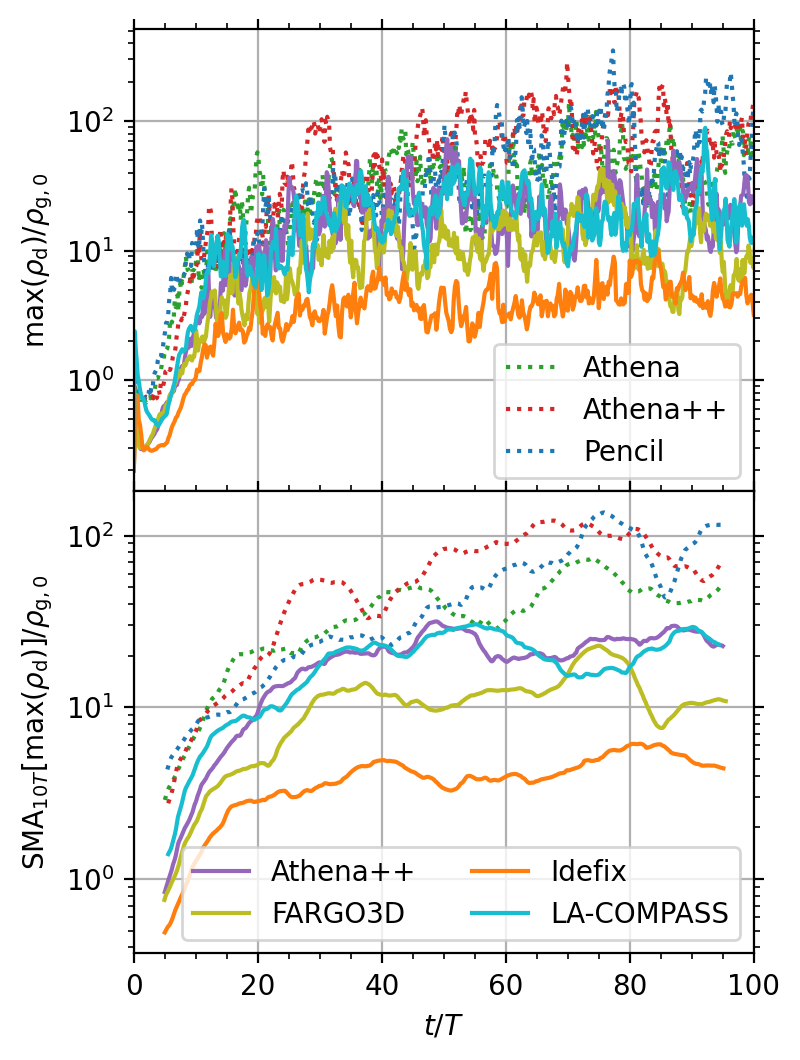

In [3]:
#===============================================================================
dt = 10  # [T]

# Lowest cadence
path = f'{root}/{model}/{problem}/dust_fluid/{res}/FARGO3D'
n_min = len(np.load(f'{path}/time_series.npz')['t'])

# Plot
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(4, 6), dpi=200)
for k, ver in enumerate(vers):
    for j, code in enumerate(plt_codes[k]):
        print(f'{code[0]} samples\n=======================')
        path = f'{root}/{model}/{problem}/{ver[0]}/{res}/{code[0]}'
        data = np.load(f'{path}/time_series.npz')
        t = data['t']
        print(f'\t  Total: {len(t)}')
        step = len(t)//n_min
        if step < 2:
            step = 1 if len(t)%n_min/n_min < 0.5 else 2
        print(f'\tStrided: {len(t[::step])}')
        axs[0].plot(t[::step], data['maxrhop'][::step], c=code[1], ls=ver[1])
        # SMA
        window = len(t)//int(t[-1]/dt)
        print(f'\tPer {dt}T: {window}')
        df = pd.DataFrame(data=data['maxrhop'], index=t)
        df['sma'] = df.rolling(window, center=True).mean()
        axs[1].plot(df['sma'], c=code[1], ls=ver[1])
        axs[k].plot([], [], c=code[1], label=code[0], ls=ver[1])

# Format plots
for ax in axs:
    ax.grid()
    ax.minorticks_on()
    ax.set(yscale='log')
    ax.tick_params(axis='both', which='both', top=True, right=True)
axs[0].legend()
axs[1].legend(ncol=2)
axs[0].set(ylabel=rf'$\max(\rho_\mathrm{{d}})/\rho_\mathrm{{g,0}}$')
axs[1].set(xlabel=r'$t/T$', xlim=(0, 100), #ylim=(3e-2, 3e2),
           ylabel=rf'$\mathrm{{SMA}}_{{{dt}T}}[\max(\rho_\mathrm{{d}})]$'\
                  +r'$/\rho_\mathrm{{g,0}}$')
fig.subplots_adjust(hspace=0)
plt.savefig(f'{problem}-{res}_time_series.pdf', bbox_inches='tight',
            pad_inches=0.01)
plt.savefig(f'{problem}-{res}_time_series.png', dpi=600, bbox_inches='tight',
            pad_inches=0.01)

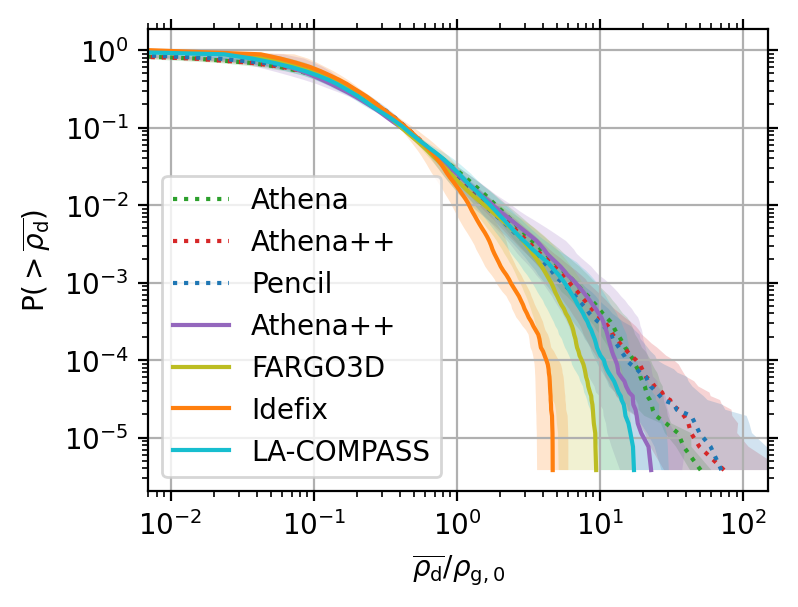

In [2]:
#===============================================================================
times = [20, 50, 100]  # [T]

# Plot
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
indices = -np.unique(np.logspace(np.log2(res**2), 0, num=100, base=2, dtype=int))
for k, ver in enumerate(vers):
    for j, code in enumerate(plt_codes[k]):
        path = f'{root}/{model}/{problem}/{ver[0]}/{res}/{code[0]}'
        rhops = []
        for i, time in enumerate(times):
            snapshot = np.load(f'{path}/{time}.npz')
            sort = np.sort(snapshot['rhop'], axis=None)
            rhops.append(sort)
        rhops = np.asarray(rhops)
        avgs = np.average(rhops, axis=0)
        cdf = np.linspace(1, 0, avgs.size, endpoint=False)
        log = np.log(np.clip(rhops, 1e-45, None))
        std_log = np.std(log, axis=0)
        stds = np.clip(np.exp(std_log), None, 3)
        cdf = np.take_along_axis(cdf, indices, 0)
        avgs = np.take_along_axis(avgs, indices, 0)
        stds = np.take_along_axis(stds, indices, 0)
        ax.plot(avgs, cdf, c=code[1], label=code[0], ls=ver[1])
        ax.fill_betweenx(cdf, avgs/stds, avgs*stds, alpha=0.2, color=code[1],
                         ec=None)

# Format plots
ax.grid()
ax.legend()
ax.minorticks_on()
ax.set(xlim=(7e-3, 1.5e2), xscale='log', yscale='log', 
       xlabel=r'$\overline{\rho_\mathrm{d}}/\rho_\mathrm{g,0}$',
       ylabel=r'P$(>\overline{\rho_\mathrm{d}})$')
ax.tick_params(axis='both', which='both', top=True, right=True)
plt.savefig(f'{problem}-{res}_CDF.pdf', bbox_inches='tight',
            pad_inches=0.01)
plt.savefig(f'{problem}-{res}_CDF.png', dpi=600, bbox_inches='tight',
            pad_inches=0.01)